# Tiling Algorithm

Here is where I play with the tiling algorithm

In [1]:
%matplotlib inline

In [2]:
def get_redshift(cat):
    
    z = (u.Quantity(cat['cz']) / c.c).to(u.dimensionless_unscaled)
    MK = cat['Ktmag'] - cosmo.distmod(z)
    
    return z

We can find samples here: https://dcc.ligo.org/P1500071/public

In [3]:
import healpy as hp
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from matplotlib import pyplot as plt
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Column
import astropy.units as u
import astropy.constants as c
from matplotlib import colors
import math as m
import numpy as np

from astropy.coordinates import EarthLocation
from pytz import timezone
from astroplan import Observer
from astropy.time import Time

from astroquery.skyview import SkyView
from astropy.coordinates import SkyCoord
from astroquery.irsa_dust import IrsaDust
from astropy.io import fits as pyfits
import glob
#!pip install aplpy
import aplpy

from astropy.utils.data import download_file

url = ('https://dcc.ligo.org/P1500071/public/10202_bayestar.fits.gz')
filename = download_file(url, cache=True)

from astroquery.vizier import Vizier

Vizier.ROW_LIMIT = -1
cat, = Vizier.get_catalogs('J/ApJS/199/26/table3')
len(cat)

z = get_redshift(cat)

#prob = hp.read_map(filename)

#prob, distmu, distsigma, distnorm = hp.read_map(filename, field=[0, 1, 2, 3])

prob, distmu, distsigma, distnorm = hp.read_map(filename, field=range(4))

npix = len(prob)
print(npix)
nside = hp.npix2nside(npix)
pixarea = hp.nside2pixarea(nside)
pixarea

/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/student/student_i4/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2287: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/student/student_i4/miniconda3/lib/python3.5/site-packages/astropy/cosmology/core.py:1414: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
3145728


3.994741635118857e-06

In [4]:
cat_now = cat
print(type(cat))

<class 'astropy.table.table.Table'>


In [5]:
r = cosmo.luminosity_distance(z).to('Mpc').value
theta = 0.5*np.pi - cat_now['_DEJ2000'].to('rad').value
phi = cat_now['_RAJ2000'].to('rad').value
ipix = hp.ang2pix(nside, theta, phi)

/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/student/student_i4/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2287: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [6]:
dp_dV = prob[ipix]*distnorm[ipix]*norm(distmu[ipix], distsigma[ipix]).pdf(r) / pixarea

/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
/student/student_i4/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:872: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


In [7]:
cands = cat_now[(dp_dV >= np.nanpercentile(dp_dV,95)) & (r <= 50.0)]


/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


In [8]:
print(len(cands))

602


In [9]:
cands['ID'][0]

b'12294679+0800014'

In [ ]:
lon = 149.06119444444445 * u.deg
lat = -31.273361111111114 * u.deg
ele = 1149.000000001551 * u.m
az = np.array([0, 90, 180, 270])

loc = {'lon': np.radians(lon), 'lat': np.radians(lat), 'ele': np.radians(ele), 'az': np.radians(az)]

location = EarthLocation.from_geodetic(longitude, latitude, elevation)
observer = Observer(name='Siding Spring Observatory',location=location)

In [ ]:
def observable(time, obs_time, loc, observer):
    
    dec = np.asin(np.sin(loc['ele'])*np.sin(loc['lat']) + np.cos(loc['ele'])*np.cos(loc['lat'])*np.cos(az))

    

In [10]:
def isnt_in(coords, covered_coords):
    isnt_in = True
    if len(covered_coords) > 0:
        for cov_cord in covered_coords:
            if abs(coords[0]-cov_cord[0]) <= 5.0 and abs(coords[1]-cov_cord[1]) <= 5.0:
                isnt_in = False

    return isnt_in

In [11]:

def get_tile_cands(cands):
    %%time
    tile_cands = []
    max_score = {}
    max_score['score'] = []
    max_score['coords'] = []
    ra_corr = cands['_RAJ2000']*np.cos(np.radians(cands['_DEJ2000']))
    k = 0
    foo = True
    for cand in cands:
        #if foo == True:
            if k%100 == 0:
                print('indexing... ' + str(k))

            ra = cand['_RAJ2000']
            dec = cand['_DEJ2000']
            coords = SkyCoord(ra, dec, frame='fk5', unit='deg')

            # Top Left
            top_left = {}
            top_left['name'] = 'Top Left on ' + str(cand['SimbadName'])
            top_left['ra_min'] = np.float64((ra - 0.05)*np.cos(coords.dec.to('radian')))
            top_left['ra_max'] = np.float64((ra + 2.55)*np.cos(coords.dec.to('radian')))
            top_left['dec_max'] = np.float64(dec + 0.05)
            top_left['dec_min'] = np.float64(dec - 1.95)
            top_left['center_ra'] = 0.5*(top_left['ra_min'] + top_left['ra_max'])
            top_left['center_dec'] = 0.5*(top_left['dec_min'] + top_left['dec_max'])

            # Top Right
            top_right = {}
            top_right['name'] = 'Top Right on ' + str(cand['SimbadName'])
            top_right['ra_max'] = np.float64((ra + 0.05)*np.cos(coords.dec.to('radian')))
            top_right['ra_min'] = np.float64((ra - 2.55)*np.cos(coords.dec.to('radian')))
            top_right['dec_max'] = top_left['dec_max']
            top_right['dec_min'] = top_left['dec_min']
            top_right['center_ra'] = 0.5*(top_right['ra_min'] + top_right['ra_max'])
            top_right['center_dec'] = top_left['center_dec']

            # Bottom Left
            bottom_left = {}
            bottom_left['name'] = 'Bottom Left on ' + str(cand['SimbadName'])
            bottom_left['ra_min'] = top_left['ra_min']
            bottom_left['ra_max'] = top_left['ra_max']
            bottom_left['dec_min'] = np.float64(dec - 0.05)
            bottom_left['dec_max'] = np.float64(dec + 1.95)
            bottom_left['center_ra'] = top_left['center_ra']
            bottom_left['center_dec'] = 0.5*(bottom_left['dec_min'] + bottom_left['dec_max'])

            # Bottom Right
            bottom_right = {}
            bottom_right['name'] = 'Bottom Right on ' + str(cand['SimbadName'])
            bottom_right['ra_max'] = top_right['ra_max']
            bottom_right['ra_min'] = top_right['ra_min']
            bottom_right['dec_min'] = bottom_left['dec_min']
            bottom_right['dec_max'] = bottom_left['dec_max']
            bottom_right['center_ra'] = top_right['center_ra']
            bottom_right['center_dec'] = bottom_left['center_dec']

            # Centered
            centered = {}
            centered['name'] = 'Centered on ' + str(cand['SimbadName'])
            centered['ra_min'] = np.float64((ra - 1.3)*np.cos(coords.dec.to('radian')))
            centered['ra_max'] = np.float64((ra + 1.3)*np.cos(coords.dec.to('radian')))
            centered['dec_max'] = np.float64(dec + 1.0)
            centered['dec_min'] = np.float64(dec - 1.0)
            centered['center_ra'] = ra*np.cos(np.radians(dec))
            centered['center_dec'] = dec

            cords = [top_left,top_right,bottom_left,bottom_right,centered]

            for cord in cords:
                tile = {}
                tile['gal_indexes'] = []
                center_coords = SkyCoord(float(cord['center_ra']), float(cord['center_dec']), 'fk5', unit='deg')

                tile['properties'] = {'name': cord['name'],
                                      'coords': center_coords.to_string('hmsdms'),
                                      'coords_num': [cord['center_ra'], cord['center_dec']],
                                      'score': 0}

                keep = (ra_corr<=cord['ra_max']) & (ra_corr>=cord['ra_min']) & (cands['_DEJ2000']<=cord['dec_max']) & (cands['_DEJ2000']>=cord['dec_min'])

                cands2 = cands[keep]

                tile['galaxies'] = []

                for cand_k in cands2:


                    cand_coords = SkyCoord(float(cand_k['_RAJ2000']*np.cos(np.radians(cand_k['_DEJ2000']))), float(cand_k['_DEJ2000']), frame='fk5', unit='deg')

                    tile['galaxies'].append({'name': cand_k['SimbadName'],
                                             'coords': cand_coords.to_string('hmsdms'),
                                             'anything else': 'other stuff'})

                    tile['gal_indexes'].append(cand_k['index'])

                tile['properties']['score'] = len(tile['galaxies'])

                if tile['properties']['score'] < 10:
                    foo = False

                #if tile['properties']['score'] >= max(max_score['score']):
                tile_cands.append(tile)
                max_score['score'].append(tile['properties']['score'])
                #print('New max score: ', max(max_score['score']))
                max_score['coords'].append(tile['properties']['coords_num'])

            k = k+1
        
    return tile_cands, max_score

In [38]:
def get_tiles(cands, tile_cands, max_score, tiles):
    
    appended = 0
    
    new_cands = cands
    max_scores = np.array(max_score['score'])
    len_max = len(max_scores[max_scores >= np.nanpercentile(max_scores, 98)])

    scores = np.array(max_score['score'])
    coords = np.array(max_score['coords'])
    indexes = np.argsort(-scores)
    scores = scores[indexes]
    coords = coords[indexes]
    tile_cands = np.array(tile_cands)
    tile_cands = tile_cands[indexes]
    
    #if len_max >= 50:
    #    sort = {'score': scores[:50], 'coords': coords[:50]}
    #else:
        
    sort = {'score': scores[:len_max], 'coords': coords[:len_max]}

    print(sort)
    range_covered = []
    gal_indexes = []
    for j in range(len(tile_cands)):
        if len(tiles)<16:
            tile = tile_cands[j]
        #print(tile['properties'])
            if tile['properties']['score'] in sort['score'] and isnt_in(tile['properties']['coords_num'], range_covered)==True:
                appended = appended + 1
                tiles.append(tile)
                if len(tile['gal_indexes']) > 0:
                    for ind in tile['gal_indexes']:
                        if ind not in gal_indexes:
                            gal_indexes.append(ind)
            #print('Appended!')
                range_covered.append(tile['properties']['coords_num'])

            
    galaxy_indexes = np.array(gal_indexes)
    new_cands.remove_rows(galaxy_indexes[np.argsort(-galaxy_indexes)])

    return new_cands

In [39]:
def tile_sky(cands):
    
    cands = cat_now[(dp_dV >= np.nanpercentile(dp_dV,95)) & (r <= 50.0)]
    cands = cands[cands['_DEJ2000'] <= 18.0]
    
    
    
    tiles = []
    loop_cands = cands
    one_to_n = np.arange(len(loop_cands))
    idx = Column(name='index', data=one_to_n)
    loop_cands.add_column(idx, index=0)
    while len(tiles) < 16:
        print(len(tiles))
        print(str(len(loop_cands))+' candidates left')
        
        tile_cands, max_score = get_tile_cands(loop_cands)
        
        loop_cands = get_tiles(loop_cands, tile_cands, max_score, tiles)
        
        
        
        loop_cands.remove_column('index')
        one_to_n = np.arange(len(loop_cands))
        idx = Column(name='index', data=one_to_n)
        loop_cands.add_column(idx, index=0)
        
    return tiles

In [40]:
cands = cat_now[(dp_dV >= np.nanpercentile(dp_dV,95)) & (r <= 50.0)]

cands = cands[cands['_DEJ2000'] <= 18.0]
print(len(cands))
len_cands = len(cands)



#cands.show_in_notebook()

484


/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


In [41]:
%%time

tiles = tile_sky(cands)

0
484 candidates left
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.54 µs
indexing... 0


indexing... 100
indexing... 200
indexing... 300
indexing... 400
{'score': array([32, 32, 30, 30, 30, 30, 30, 30, 30, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
       26, 26, 26, 26]), 'coords': array([[ 182.75491433,   12.43355   ],
       [ 182.82137968,   12.46107   ],
       [ 182.13190678,   12.61085   ],
       [ 182.80732757,   12.57475   ],
       [ 182.06988583,   13.079     ],
       [ 182.26134898,   13.24192   ],
       [ 182.21038956,   12.73481   ],
       [ 182.23026407,   13.22046   ],
       [ 182.22708734,   13.26736   ],
       [ 182.32690423,   13.18385   ],
       [ 182.96007451,   12.75088   ],
       [ 184.08160689,    6.24163   ],
       [ 183.33343717,   12.3911    ],
       [ 182.61998339,   12.31594   ],
       [ 182.98642785,   13.09915   ],
       [ 183.02401277,   13.15499   ],
       [ 182.58136987,   12.29033   ],
   

indexing... 100
indexing... 200
indexing... 300
indexing... 400
{'score': array([25, 24, 24, 23, 23, 23, 23, 22, 22, 21, 21, 20, 20, 20, 20, 20, 20,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 18]), 'coords': array([[ 185.40470508,   12.1344    ],
       [ 185.45361715,   12.21287   ],
       [ 185.68623864,   12.12643   ],
       [ 185.8507448 ,   12.16002   ],
       [ 185.41623437,   11.81809   ],
       [ 185.46167369,   11.72948   ],
       [ 185.42545422,   11.80038   ],
       [ 185.61813604,   11.60604   ],
       [ 185.70058161,   12.21318   ],
       [ 185.73209757,   11.43202   ],
       [ 185.34382004,   12.33719   ],
       [ 186.09323576,   11.10575   ],
       [ 186.27887652,   12.02159   ],
       [ 185.35582693,   11.43929   ],
       [ 185.81867052,   11.31399   ],
       [ 185.36285532,   12.59693   ],
       [ 186.27306263,   12.14052   ],
   

indexing... 100
indexing... 200
indexing... 300
{'score': array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18,
       18, 18, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 16, 16, 16,
       16, 15, 15, 15, 15, 15, 15, 15, 15, 15]), 'coords': array([[ 185.57448694,    8.64914   ],
       [ 185.18595503,    8.75016   ],
       [ 185.84160241,    8.26752   ],
       [ 184.45667279,    8.88458   ],
       [ 185.51699522,    8.85362   ],
       [ 185.51729158,    8.6051    ],
       [ 184.60504453,    8.64195   ],
       [ 185.71944685,    8.36012   ],
       [ 184.45158868,    8.38282   ],
       [ 184.64907444,    8.4357    ],
       [ 185.51217041,    8.47055   ],
       [ 184.73292618,    9.06672   ],
       [ 184.4516773 ,    8.09357   ],
       [ 185.76821405,    8.4863    ],
       [ 185.0131837 ,    8.15434   ],
       [ 185.89858468,    8.39451   ],
       [ 184.77078826,    8.22482   ],
       [ 184.42452448,    8.77404   ],
       [ 185.3373603 ,    8.634

indexing... 100
indexing... 200
indexing... 300
{'score': array([12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10]), 'coords': array([[ 179.12506428,   13.74833   ],
       [ 179.09178644,   13.02384   ],
       [ 193.29408865,   -7.57529   ],
       [ 179.21210738,   13.48285   ],
       [ 183.82540651,   10.12159   ],
       [ 184.45158868,   10.28282   ],
       [ 178.52864772,   12.9667    ],
       [ 193.3914978 ,   -7.57217   ],
       [ 184.58684321,   10.15754   ],
       [ 179.50028063,   13.07899   ],
       [ 179.39561578,   12.29649   ],
       [ 179.65020141,   12.47479   ],
       [ 179.15301162,   13.1494    ],
       [ 179.86261945,   12.2229    ],
       [ 193.76281974,   -7.71077   ],
       [ 178.64551095,   13.1729    ],
       [ 191.96296727,  -15.55888   ],
       [ 193.78077808,   -7.44384   ],
       [ 183.78280906,    8.19835   ],
       [ 184.451

indexing... 100
indexing... 200
{'score': array([10, 10,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8]), 'coords': array([[ 183.78280906,    8.19835   ],
       [ 188.22487691,   11.1261    ],
       [ 183.8206516 ,    8.41208   ],
       [ 188.2230801 ,   10.63247   ],
       [ 187.5498377 ,   11.15348   ],
       [ 195.28715677,  -12.57179   ],
       [ 190.14775172,    3.38608   ],
       [ 195.25977116,  -12.48867   ],
       [ 182.76341801,    7.58585   ],
       [ 195.18362687,  -13.22645   ],
       [ 190.6923715 ,    3.60741   ],
       [ 189.5818601 ,    3.60381   ],
       [ 188.13254464,   10.49247   ],
       [ 195.15290117,  -13.20677   ],
       [ 188.06520359,   11.86208   ],
       [ 188.55406596,   11.10575   ],
       [ 183.12210676,    7.98881   ],
       [ 190.65168767,   -0.70603   ],
       [ 189.72463257,    3.13788   ],
       [ 183.36196355,    8.26752   ],
       [ 182.9758795 ,    7.

indexing... 100
indexing... 200
{'score': array([10,  9,  9,  8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6]), 'coords': array([[  1.88224877e+02,   1.11261000e+01],
       [  1.88223080e+02,   1.06324700e+01],
       [  1.87549838e+02,   1.11534800e+01],
       [  1.88132545e+02,   1.04924700e+01],
       [  1.88554066e+02,   1.11057500e+01],
       [  1.88065204e+02,   1.18620800e+01],
       [  1.91883251e+02,  -1.03254000e+00],
       [  1.87482973e+02,   1.11329700e+01],
       [  1.90651688e+02,  -7.06030000e-01],
       [  1.88273639e+02,   1.06026100e+01],
       [  1.86471035e+02,   6.29663000e+00],
       [  1.90952977e+02,  -5.61280000e-01],
       [  1.87597917e+02,   6.72695000e+00],
       [  1.78950779e+02,   1.62739900e+01],
       [  1.88095656e+02,   1.03636600e+01],
   

In [28]:
print(len(tiles))
for tile in tiles:
    print(tile['properties'])

16
{'score': 32, 'coords': '12h11m01.1794s +12d26m00.78s', 'coords_num': [182.75491432986706, 12.433549999999999], 'name': "Bottom Right on b'2MASX J12305713+1129007'"}
{'score': 29, 'coords': '12h16m19.5857s +06d14m29.868s', 'coords_num': [184.08160689193619, 6.2416299999999998], 'name': "Top Left on b'2MASX J12170991+0711299'"}
{'score': 25, 'coords': '12h21m37.1292s +12d08m03.84s', 'coords_num': [185.40470508281982, 12.134399999999999], 'name': "Bottom Right on b'2MASX J12405858+1111038'"}
{'score': 18, 'coords': '11h59m38.0232s +15d31m12s', 'coords_num': [179.9084299880451, 15.52], 'name': "Top Left on b'2MASX J12252551+1628120'"}
{'score': 12, 'coords': '12h53m10.5813s -07d34m31.044s', 'coords_num': [193.29408864970776, -7.5752900000000007], 'name': "Bottom Left on b'2MASX J12564890-0831310'"}
{'score': 19, 'coords': '12h22m02.9209s +08d28m13.98s', 'coords_num': [185.51217041065513, 8.4705500000000011], 'name': "Top Left on b'2MASX J12271158+0925138'"}
{'score': 15, 'coords': '12h

In [ ]:
cands.show_in_notebook()

In [42]:
cands_hist = cat_now[(dp_dV >= np.nanpercentile(dp_dV,95)) & (r <= 50.0)]

cands_hist = cands_hist[cands_hist['_DEJ2000'] <= 18.0]
print(len(cands_hist))
len_cands = len(cands_hist)

org_ra = []
org_dec =[]

for ra_ind in range(len(cands_hist['_RAJ2000'])):
    org_dec.append(cands_hist['_DEJ2000'][ra_ind])
    org_ra.append(cands_hist['_RAJ2000'][ra_ind]*m.cos(m.radians(cands_hist['_DEJ2000'][ra_ind])))

/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


484


In [43]:
tl = 0
tr = 0
br = 0
bl = 0
cent = 0

for tile in tiles:
    if 'Top Left' in tile['properties']['name']:
        tl = tl + 1
    elif 'Top Right' in tile['properties']['name']:
        tr = tr + 1
    elif 'Bottom Left' in tile['properties']['name']:
        bl = bl + 1
    elif 'Bottom Right' in tile['properties']['name']:
        br = br + 1
    elif 'Centered' in tile['properties']['name']:
        cent = cent + 1

/student/student_i4/miniconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


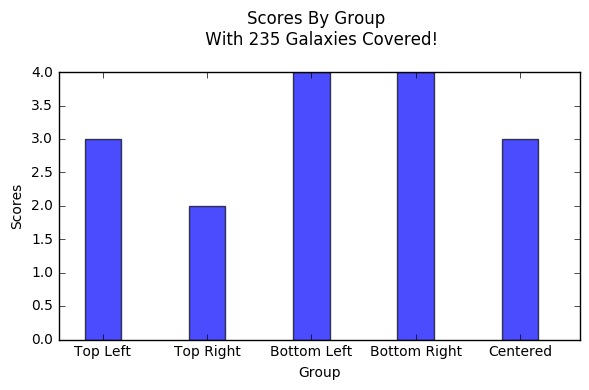

249


In [44]:
fig, ax = plt.subplots()
n_groups = 5
index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.7
error_config = {'ecolor': '0.3'}

rects1 = plt.bar(0.25 + index, [tl, tr, bl, br, cent], bar_width,
                 alpha=opacity,
                 color='b',
                 label='')


plt.xlabel('Group')
plt.ylabel('Scores')
plt.title('Scores By Group \n With ' + str(len_cands-len(cands)) + ' Galaxies Covered!\n')
plt.xticks(0.25 + index + 0.5*bar_width, ('Top Left', 'Top Right', 'Bottom Left', 'Bottom Right', 'Centered'))
plt.legend()

plt.tight_layout()
plt.show()

print(len(cands))

/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()
/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()


(-90, 90)

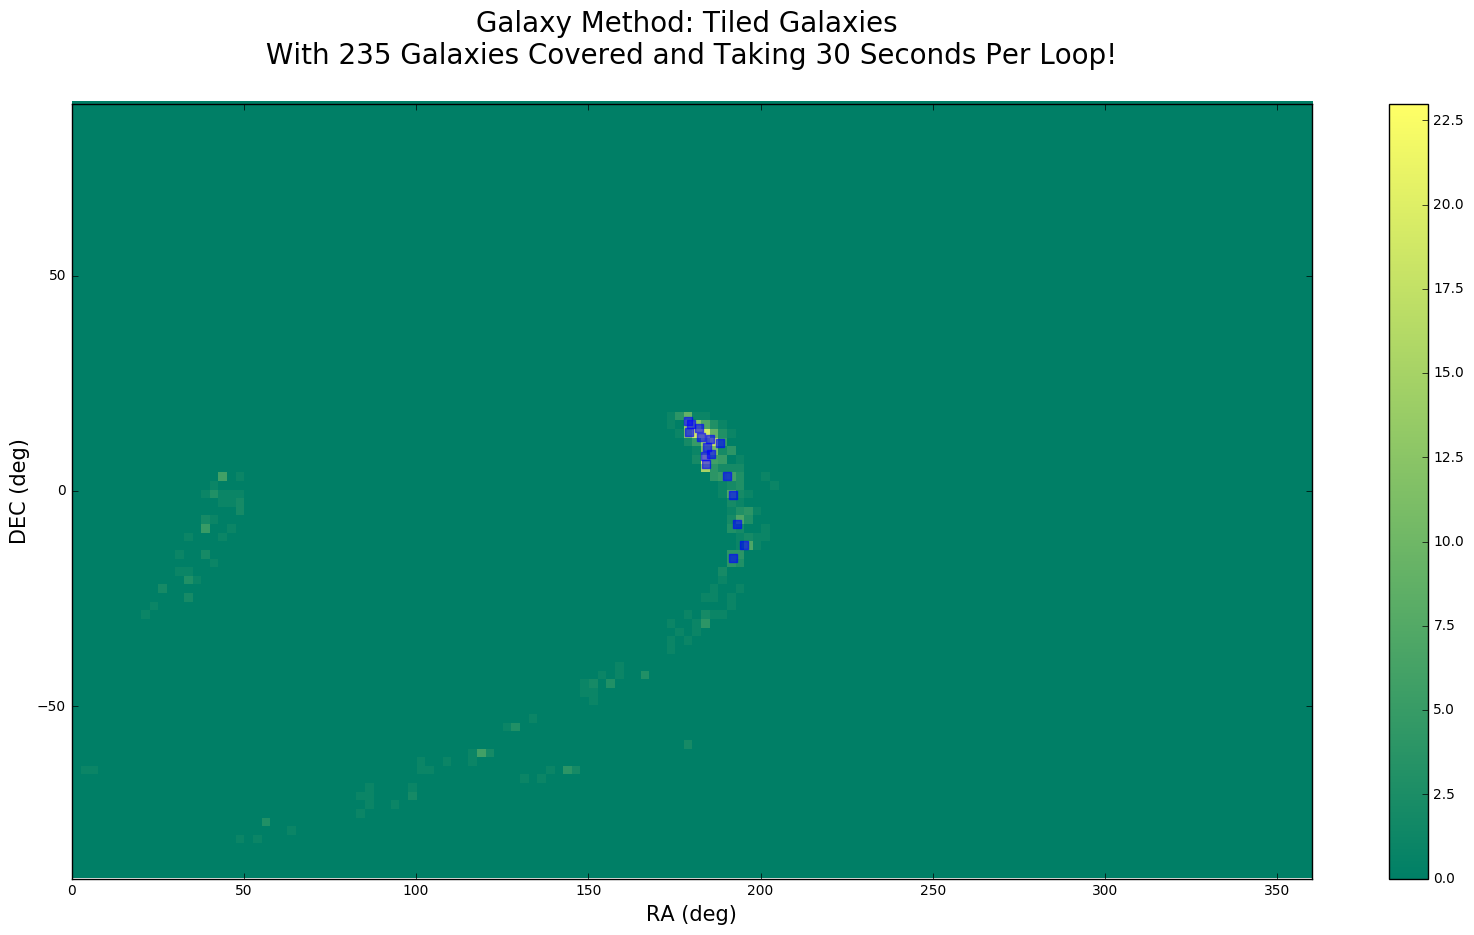

In [45]:
decs = []
ras = []
cands_hist = cat_now[(dp_dV >= np.nanpercentile(dp_dV,95)) & (r<=50.0)]
cands_hist = cands_hist[cands_hist['_DEJ2000'] <= 18.0]
for tile in tiles:
    #for gal in tile['galaxies']:
        coords = SkyCoord(tile['properties']['coords_num'][0], tile['properties']['coords_num'][1], unit='deg', frame='fk5')
        decs.append(coords.dec.deg)
        ras.append(coords.ra.deg)
plt.figure(figsize=(20,10))
from matplotlib import cm
afm_cmap = cm.summer
afm_cmap.set_under("w") # sets background to white
plt.hist2d(org_ra, org_dec, bins = [144, 90],range=np.array([(0,360), (-90,90)]), cmap = afm_cmap)
plt.colorbar()

plt.scatter(ras, decs, color='b', s=40, alpha=.6, marker = 's')


plt.xlabel('RA (deg)', fontsize = 15)
plt.ylabel('DEC (deg)', fontsize = 15)
plt.title('Galaxy Method: Tiled Galaxies \n With ' + str(len_cands-len(cands)) + ' Galaxies Covered and Taking '
          + str(30) + ' Seconds Per Loop! \n', fontsize = 20)
plt.xlim([0,360])
plt.ylim([-90,90])

(-90, 90)

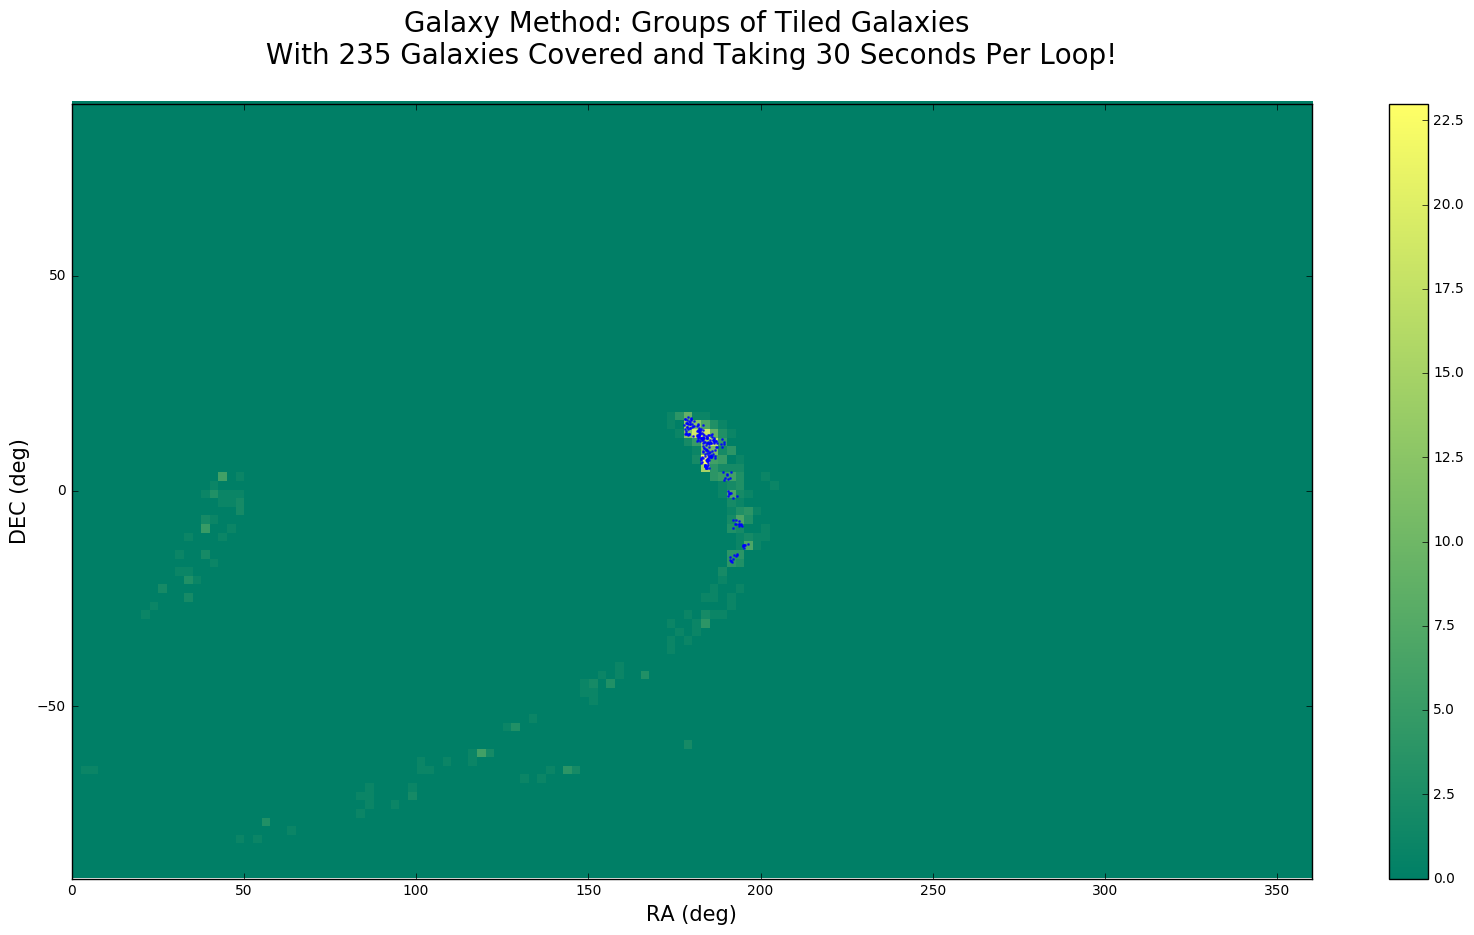

In [46]:
decs = []
ras = []

for tile in tiles:
    for gal in tile['galaxies']:
        coords = SkyCoord(gal['coords'], frame='fk5')
        decs.append(coords.dec.deg)
        ras.append(coords.ra.deg)
plt.figure(figsize=(20,10))
from matplotlib import cm
afm_cmap = cm.summer
afm_cmap.set_under("w") # sets background to white
plt.hist2d(org_ra, org_dec, bins = [144, 90],range=np.array([(0,360), (-90,90)]), cmap = afm_cmap)
plt.colorbar()

plt.scatter(ras, decs, color='b', s=1, alpha=.7)


plt.xlabel('RA (deg)', fontsize = 15)
plt.ylabel('DEC (deg)', fontsize = 15)
plt.title('Galaxy Method: Groups of Tiled Galaxies \n With ' + str(len_cands-len(cands)) + ' Galaxies Covered and Taking '
          + str(30) + ' Seconds Per Loop! \n', fontsize = 20)
plt.xlim([0,360])
plt.ylim([-90,90])
#plt.colorbar()

## Histogram Method

In [47]:
cands_hist = cat_now[(dp_dV >= np.nanpercentile(dp_dV,95)) & (r<=50.0)]
cands_hist = cands_hist[cands_hist['_DEJ2000'] <= 18.0]
print(len(cands_hist))

484


/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
/student/student_i4/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in less_equal
  if __name__ == '__main__':


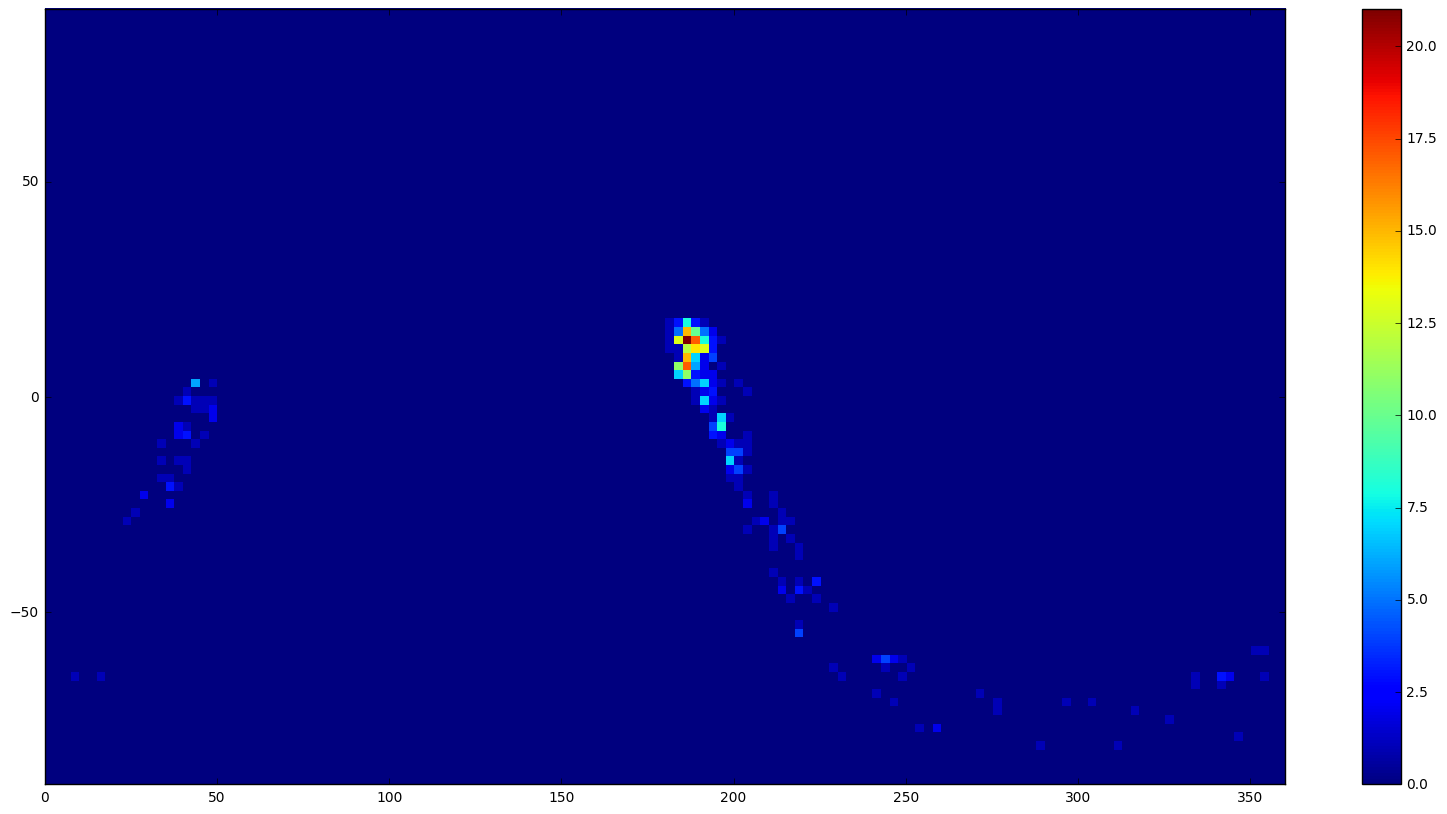

In [48]:
#histo, xes, ys = plt.hist2d(cands_hist['_RAJ2000'], cands_hist['_DEJ2000'], bins = [144, 180],range=np.array([(0,360), (-90,90)]))

plt.figure(figsize=(20,10))
plt.hist2d(cands_hist['_RAJ2000'], cands_hist['_DEJ2000'], bins = [144, 90],range=np.array([(0,360), (-90,90)]))

plt.colorbar()



In [ ]:
histo, xes, ys, img = plt.hist2d(cands_hist['_RAJ2000'], cands_hist['_DEJ2000'], bins = [139, 90],range=np.array([(0,360), (-90,90)]))

In [ ]:
print(histo)

In [49]:
foo= True
def find_score(histo):
#if foo == True:
    tls = {'score': [], 'row': [], 'colmn': []}

    for k in range(len(histo)):
        row = k
        colmn = np.where(histo[k]==max(histo[k]))
        for col in colmn:
            for co in col:
                tls['score'].append(max(histo[k]))
                tls['row'].append(row)
                tls['colmn'].append(co)

    tls['score']=np.array(tls['score'])
    tls['row']=np.array(tls['row'])
    tls['colmn']=np.array(tls['colmn'])

    indexes_of_max = np.argsort(-tls['score'])
    sorted_tls = {'score': tls['score'][indexes_of_max],
                  'row': tls['row'][indexes_of_max],
                  'colmn': tls['colmn'][indexes_of_max],
                  'score_overall': 0}

    #print(sorted_tls['score'][:16])
    #print(sorted_tls['colmn'][:16])
    #print(sorted_tls['row'][:16])
    sorted_tls['score_overall'] = sum(sorted_tls['score'][:15])
    #print(sorted_tls['score_overall'])
    
    return sorted_tls

In [50]:
org_ra = []
org_dec =[]

for ra_ind in range(len(cands_hist['_RAJ2000'])):
    org_dec.append(cands_hist['_DEJ2000'][ra_ind])
    org_ra.append(cands_hist['_RAJ2000'][ra_ind]*m.cos(m.radians(cands_hist['_DEJ2000'][ra_ind])))

New max score!  127.0
New max score!  133.0
New max score!  163.0
New max score!  165.0
New max score!  167.0
New max score!  170.0
CPU times: user 1min 24s, sys: 24 ms, total: 1min 24s
Wall time: 1min 24s


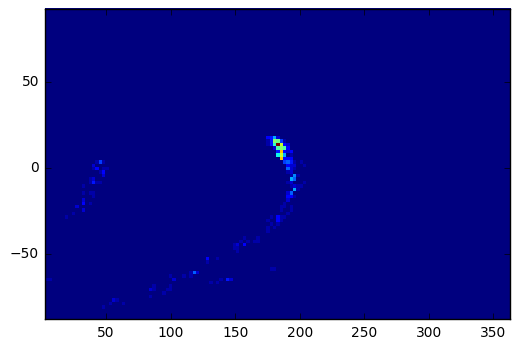

In [51]:


%%time
ra_fov = 2.6
dec_fov = 2.0

N_steps_ra = 50
N_steps_dec = 20
tiles_histo = {}
tiles_histo['RA'] = []
tiles_histo['DEC'] = []
n_fin = -1
mn_fin = -1

max_score = -1

for n in range(N_steps_dec):
    
    min_dec = -90 + n*dec_fov/N_steps_dec
    max_dec = 90 + n*dec_fov/N_steps_dec
    
    for mn in range(N_steps_ra):
        
        min_ra = 0 + mn*ra_fov/N_steps_ra
        max_ra = 360 + mn*ra_fov/N_steps_ra
        
        histo, xes, ys, img = plt.hist2d(org_ra,
                                         org_dec, bins = [139, 90], 
                                         range=np.array([(min_ra,max_ra),
                                                         (min_dec,max_dec)]))
        sorted_tls = find_score(histo)
        
        if sorted_tls['score_overall'] > max_score:
            tiles_histo = sorted_tls
            max_score = sorted_tls['score_overall']
            print('New max score! ', max_score)
            n_fin  = n
            mn_fin = mn

tiles_histo['RA'] = []
tiles_histo['DEC'] = []
for ra_ind in range(len(tiles_histo['row'])):
    tiles_histo['DEC'].append(-90+mn*dec_fov/N_steps_dec + 180*(tiles_histo['colmn'][ra_ind]+0.5)/90)
    tiles_histo['RA'].append((mn*ra_fov/N_steps_ra + 360*(tiles_histo['row'][ra_ind]+0.5)/139))
                             #*m.cos(m.radians(tiles_histo['DEC'][ra_ind])))

(-90, 90)

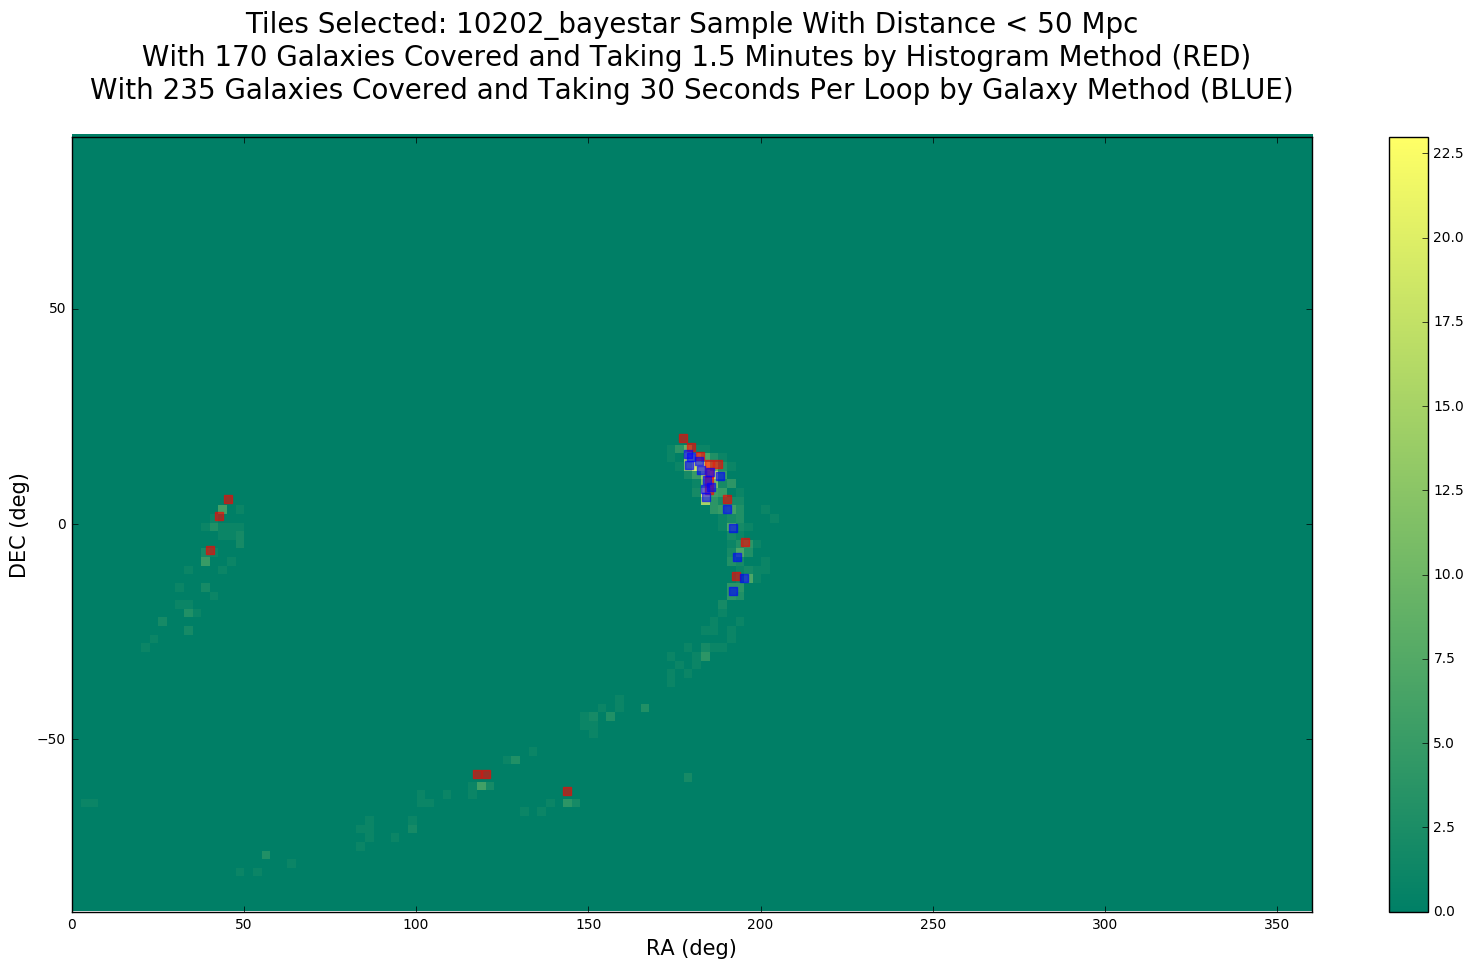

In [52]:
decs = []
ras = []

for tile in tiles:
    #for gal in tile['galaxies']:
        coords = SkyCoord(tile['properties']['coords_num'][0], tile['properties']['coords_num'][1], unit='deg', frame='fk5')
        decs.append(coords.dec.deg)
        ras.append(coords.ra.deg)



plt.figure(figsize=(20,10))
from matplotlib import cm
afm_cmap = cm.summer
afm_cmap.set_under("w") # sets background to white
plt.hist2d(org_ra, org_dec, bins = [144, 90],range=np.array([(0,360), (-90,90)]), cmap = afm_cmap)
plt.colorbar()

plt.scatter(tiles_histo['RA'][:17], tiles_histo['DEC'][:17], marker='s', color='r', s=40, alpha=.6)
plt.scatter(ras, decs, marker='s', color='b', s=40, alpha=.6)

plt.xlabel('RA (deg)', fontsize = 15)
plt.ylabel('DEC (deg)', fontsize=15)
plt.title('Tiles Selected: 10202_bayestar Sample With Distance < 50 Mpc\n With ' + str(int(tiles_histo['score_overall'])) 
          + ' Galaxies Covered and Taking ' + str(1.5) + ' Minutes by Histogram Method (RED)\n'+ 'With '
          + str(len_cands-len(cands)) + ' Galaxies Covered and Taking '+ str(30) +
          ' Seconds Per Loop by Galaxy Method (BLUE)\n', fontsize=20)
plt.xlim([0,360])
plt.ylim([-90,90])

In [ ]:
print(tiles_histo['score_overall'])
for k in range(len(tiles_histo['score'][:16])):
    print('score, ',tiles_histo['score'][k])
